In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc
import xgboost
from xgboost import XGBRegressor
import optuna

CPU times: user 2.09 s, sys: 1.19 s, total: 3.28 s
Wall time: 3.08 s


In [2]:
## loading final data

In [3]:
combined = pd.read_csv("models/final_data.csv")

In [4]:
combined.head()

,Unnamed: 0,row_id,country,store,product,num_sold,holiday,store_emb_1,store_emb_2,store_emb_3,...,Elapsed,is_weekend,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
0,0,0,Finland,KaggleMart,Kaggle Mug,5.796058,in_Finland,0.967750,-0.929185,1.117330,...,1.420070e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
1,1,1,Finland,KaggleMart,Kaggle Hat,6.253829,in_Finland,0.967750,-0.929185,1.117330,...,1.420070e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
2,2,2,Finland,KaggleMart,Kaggle Sticker,4.983607,in_Finland,0.967750,-0.929185,1.117330,...,1.420070e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
3,3,3,Finland,KaggleRama,Kaggle Mug,6.349139,in_Finland,-0.300273,0.358641,-0.296122,...,1.420070e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
4,4,4,Finland,KaggleRama,Kaggle Hat,6.814543,in_Finland,-0.300273,0.358641,-0.296122,...,1.420070e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802


In [5]:
combined.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [6]:
train_cond = combined.year < 2018
valid_cond = combined.year == 2018
train_idx = np.where(train_cond)[0]
valid_idx = np.where(valid_cond)[0]

In [7]:
train_idx

array([    0,     1,     2, ..., 19725, 19726, 19727])

In [8]:
len(train_idx), len(valid_idx)

(19728, 6570)

In [9]:
test_cond = combined.year > 2018
test_idx = np.where(test_cond)[0]
print (len(test_idx))

6570


In [10]:
combined["num_sold"]

0        5.796058
1        6.253829
2        4.983607
3        6.349139
4        6.814543
           ...   
32863        -inf
32864        -inf
32865        -inf
32866        -inf
32867        -inf
Name: num_sold, Length: 32868, dtype: float64

In [11]:
dep_var = "num_sold"

In [12]:
cont, cat = cont_cat_split(combined, 1, dep_var)

In [13]:
cont

['row_id',
 'store_emb_1',
 'store_emb_2',
 'store_emb_3',
 'product_emb_1',
 'product_emb_2',
 'product_emb_3',
 'country_emb_1',
 'country_emb_2',
 'country_emb_3',
 'year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Elapsed',
 'is_weekend',
 'month_emb_1',
 'month_emb_2',
 'month_emb_3',
 'month_emb_4',
 'month_emb_5',
 'month_emb_6',
 'month_emb_7',
 'gdp']

In [14]:
cont.remove("row_id")
cont.remove("Elapsed")

In [15]:
cat

['country',
 'store',
 'product',
 'holiday',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [16]:
procs = [Categorify, FillMissing, Normalize]
#train_idx = combined.iloc[:26298]
splits = (list(train_idx), list(valid_idx))
to = TabularPandas(combined, procs, cat, cont, y_names = dep_var, splits = splits)

In [17]:
def SMAPE(preds, targs):
    denominator = (targs + np.abs(preds)) / 200.0
    diff = np.abs(preds - targs) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [18]:
smape = AccumMetric(SMAPE, to_np = True)

In [19]:
dls = to.dataloaders(1024, device = "cuda")

In [20]:
learn = tabular_learner(dls, y_range = (3, 8), n_out = 1, layers = [500, 250, 64, 32, 16], metrics = [smape],
                        loss_func = F.mse_loss)

CPU times: user 4.23 s, sys: 1.44 s, total: 5.67 s
Wall time: 6.24 s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0005754399462603033)

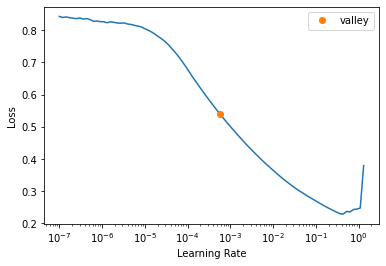

In [21]:
%%time
learn.lr_find()

In [22]:
learn.fit_one_cycle(30, slice(1e-4, 1e-1))

epoch,train_loss,valid_loss,SMAPE,time
0,0.087006,0.041372,2.791011,00:00
1,0.047210,0.120793,5.198142,00:00
2,0.031460,0.081346,4.173356,00:00
3,0.024195,0.023394,2.178077,00:00
4,0.019508,0.052047,3.283556,00:00
5,0.016775,0.039367,2.875459,00:00
6,0.015505,0.025521,2.228582,00:00
7,0.013677,0.018288,1.834640,00:00
8,0.013314,0.029043,2.071903,00:00
9,0.012086,0.011246,1.478744,00:00


In [28]:
yvalid, _ = learn.get_preds()
yvalid = np.concatenate([yvalid])
yvalid = np.squeeze(yvalid)
#yvalid = np.exp(yvalid)

In [29]:
SMAPE(yvalid, to.valid.y)

1.6746309732277471

In [30]:
validxs, validy = to.valid.xs, to.valid.y

In [31]:
import pickle
model_log = pickle.load(open("models/model_log_latest.pkl", "rb"))
model_exp = pickle.load(open("models/model_exp_latest.pkl", "rb"))

In [32]:
preds_valid_log = model_log.predict(validxs)

In [33]:
SMAPE(preds_valid_log, validy)

1.4557583214624132

In [34]:
preds_valid_exp = model_exp.predict(validxs)

In [35]:
SMAPE(preds_valid_exp, np.exp(validy))

8.104169354397024

In [36]:
from functools import partial
from scipy.optimize import fmin
class OptimizeSMAPE :
    def __init__(self):
        self.coef_ = 0
        
    def _smape(self, coef, X, y):
        '''
        coef = coef list, of the same length as the no of models
        X = predictions made by every model
        y = targets
        '''
        x_coef = X * coef
        predictions = np.sum(x_coef, axis = 1)
        # calculate the SMAPE score
        smape_score = SMAPE(predictions, y)
        
        return smape_score
    
    def fit(self, X, y):
        loss_partial = partial(self._smape, X = X, y = y)
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size = 1)
        
        self.coef_ = fmin(loss_partial, initial_coef, disp = True)
        
    def predict(self, X):
        x_coef = X * self.coef_
        predictions = np.sum(x_coef, axis = 1)
        return predictions

In [37]:
yvalid

array([5.9865494, 6.4389076, 5.2353296, ..., 6.681806 , 7.167727 ,
       5.9897695], dtype=float32)

In [38]:
yvalid = np.exp(yvalid)
preds_valid_log = np.exp(preds_valid_log)
basic_blend = (yvalid + preds_valid_log + preds_valid_exp) / 3

In [40]:
SMAPE(basic_blend, np.exp(validy))

6.302236363455058

In [41]:
stack_preds = np.column_stack((preds_valid_exp, preds_valid_log, yvalid))

In [44]:
opt = OptimizeSMAPE()

In [45]:
%%time
validy_exp = np.exp(validy)
opt.fit(stack_preds, validy_exp)

Optimization terminated successfully.
         Current function value: 6.171591
         Iterations: 106
         Function evaluations: 190
CPU times: user 408 ms, sys: 2.75 ms, total: 411 ms
Wall time: 408 ms


In [46]:
opt.coef_

array([0.47559399, 0.34828059, 0.20818296])

In [47]:
model_exp_full = pickle.load(open("models/model_exp_full_latest.pkl", "rb"))
model_log_full = pickle.load(open("models/model_log_full_latest.pkl", "rb"))

In [48]:
learn_full = load_learner("models/full_learner.pkl")

In [49]:
procs = [Categorify, FillMissing, Normalize]
#train_idx = combined.iloc[:26298]
splits = (list(train_idx), list(test_idx))
to = TabularPandas(combined, procs, cat, cont, y_names = dep_var, splits = splits)

In [50]:
testxs = to.valid.xs

In [52]:
combined_test = combined.iloc[test_idx]
display(combined_test.head(3))

,row_id,country,store,product,num_sold,holiday,store_emb_1,store_emb_2,store_emb_3,product_emb_1,...,Elapsed,is_weekend,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
26298,26298,Finland,KaggleMart,Kaggle Mug,-inf,in_Finland,0.96775,-0.929185,1.11733,-0.345529,...,1.546301e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,48712
26299,26299,Finland,KaggleMart,Kaggle Hat,-inf,in_Finland,0.96775,-0.929185,1.11733,0.764051,...,1.546301e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,48712
26300,26300,Finland,KaggleMart,Kaggle Sticker,-inf,in_Finland,0.96775,-0.929185,1.11733,-1.278340,...,1.546301e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,48712


In [53]:
dl = learn_full.dls.test_dl(combined_test)

In [54]:
ytest_nn, _ = learn_full.get_preds(dl = dl)

/tmp/ipykernel_528/884952379.py:3: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(preds - targs) / denominator


In [55]:
preds_test_log = model_log_full.predict(testxs)

In [56]:
preds_test_exp = model_exp_full.predict(testxs)

In [57]:
preds_test_log = np.exp(preds_test_log)
ytest_nn = np.concatenate([ytest_nn])
ytest_nn = np.squeeze(ytest_nn)
ytest_nn = np.exp(ytest_nn)

In [58]:
testpred_stack = np.column_stack((preds_test_exp, preds_test_log, ytest_nn))

In [59]:
testpred_stack

array([[ 404.6835 ,  404.82336,  404.1807 ],
       [ 619.34033,  586.354  ,  636.3924 ],
       [ 185.13258,  186.75986,  182.71416],
       ...,
       [ 828.2744 ,  862.848  ,  959.51624],
       [1226.2178 , 1312.9963 , 1458.6606 ],
       [ 361.97076,  393.27148,  398.17352]], dtype=float32)

In [60]:
ensemble_test_preds = opt.predict(testpred_stack)

In [61]:
ensemble_test_preds

array([ 417.60069559,  631.25631133,  191.13075169, ...,  894.19048308,
       1344.1412354 ,  392.01288785])

In [62]:
submission = pd.read_csv("sample_submission.csv")

In [63]:
submission["num_sold"] = list(ensemble_test_preds)

In [64]:
submission.to_csv("subm/submission.csv", index = False)

In [65]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "plssssss"

100%|████████████████████████████████████████| 156k/156k [00:03<00:00, 44.7kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022

In [68]:
testpred_stack

array([[ 404.6835 ,  404.82336,  404.1807 ],
       [ 619.34033,  586.354  ,  636.3924 ],
       [ 185.13258,  186.75986,  182.71416],
       ...,
       [ 828.2744 ,  862.848  ,  959.51624],
       [1226.2178 , 1312.9963 , 1458.6606 ],
       [ 361.97076,  393.27148,  398.17352]], dtype=float32)

In [70]:
basic = np.mean(testpred_stack, axis = 1)

In [71]:
basic = np.ceil(basic)

In [72]:
basic

array([ 405.,  615.,  185., ...,  884., 1333.,  385.], dtype=float32)

In [73]:
submission["num_sold"] = list(basic)

In [74]:
submission.to_csv("subm/submission.csv", index = False)

In [75]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "plssssss"

100%|██████████████████████████████████████| 77.2k/77.2k [00:07<00:00, 10.9kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022